In [0]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
(X_Train, Y_Train),(_,_) = mnist.load_data()  

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
NUM_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = math.ceil(X_Train.shape[0]/float(BATCH_SIZE))
HALF_BATCH_SIZE = int(BATCH_SIZE/2)

NOISE_DIM = 100

NUM_CLASSES = 10

adam = Adam(lr=2e-4,beta_1=0.5)

In [4]:
print(X_Train.shape)
print(type(X_Train))

X_Train = X_Train.reshape((*(X_Train.shape),1))
Y_Train  = to_categorical(Y_Train, num_classes=NUM_CLASSES)
print(X_Train.shape, Y_Train.shape)

(60000, 28, 28)
<class 'numpy.ndarray'>
(60000, 28, 28, 1) (60000, 10)


In [5]:
#Normalize the Data between -1 and 1

X_Train = (X_Train.astype('float32') - 127.5)/127.5

print(np.min(X_Train))
print(np.max(X_Train))

-1.0
1.0


In [6]:
#Upsampling 
# Start from 7 X 7 X 128
generator = Sequential()
generator.add(Dense(7*7*128))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

#Double the Activation Size 14 X 14 X 64
generator.add(UpSampling2D())
generator.add(Conv2D(64,kernel_size=(5,5),padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# Double the Activation Size 28 X 28 X 1
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))


noise_input = Input(shape=(100,))
class_input = Input(shape=(10,))
reshaped_class_input = Dense(100, activation='tanh')(class_input)

bonded = concatenate([noise_input, reshaped_class_input])

gen_out = generator(bonded)

generator = Model(inputs=[noise_input, class_input], outputs=gen_out)

# Final Output (No ReLu or Batch Norm)
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          1100        input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 200)          0           input_1[0][0]                    
                                                                 dense_1[0][0]                

In [7]:


#Discriminator - Downsampling
in_layer = Input(shape=(28,28,1))
layer = Conv2D(64,(5,5),strides=(2,2),padding='same')(in_layer)
layer = LeakyReLU(0.2)(layer)

# Prefer Strided Convolutions over MaxPooling
layer = Conv2D(128,(5,5),strides=(2,2),padding='same')(layer)
layer = LeakyReLU(0.2)(layer)

layer = Flatten()(layer)

real = Dense(1, activation='sigmoid')(layer)
class_number = Dense(NUM_CLASSES, activation='softmax')(layer)

discriminator = Model(inputs=in_layer, outputs=[real, class_number])

discriminator.compile(loss='binary_crossentropy',optimizer=adam)
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   1664        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_2 (LeakyReLU)       (None, 14, 14, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 128)    204928      leaky_re_lu_2[0][0]              
____________________________________________________________________________________________

In [17]:
gan_input = generator.input
gan_output = discriminator(generator.output)

#Functional API
model = Model(gan_input, gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          1100        input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 200)          0           input_1[0][0]                    
                                                                 dense_1[0][0]              

In [18]:
model.output

[<tf.Tensor 'model_1_1/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'model_1_1/Identity_1:0' shape=(None, 10) dtype=float32>]

In [0]:


def save_imgs(epoch,samples=25):
    noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
    classes = to_categorical(np.random.randint(0, NUM_CLASSES, samples), num_classes=NUM_CLASSES)
    generated_imgs = generator.predict([noise, classes])
    generated_imgs = generated_imgs.reshape(samples,28,28)
    
    plt.figure(figsize=(5,5))
    for i in range(samples):
        plt.subplot(5,5,i+1)
        plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_output_epoch_{0}.png'.format(epoch+1))
    plt.show()
  


In [23]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


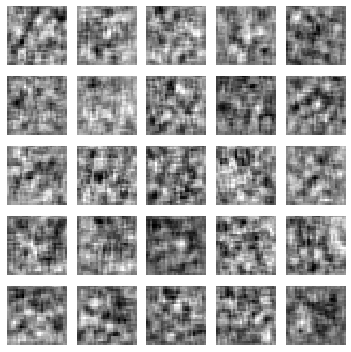

In [24]:
save_imgs(50)

In [25]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [26]:
X_Train.shape

(60000, 28, 28, 1)

oye hoye
oye hoye
oye hoye
oye hoye
oye hoye
oye hoye
oye hoye
oye hoye
oye hoye
oye hoye


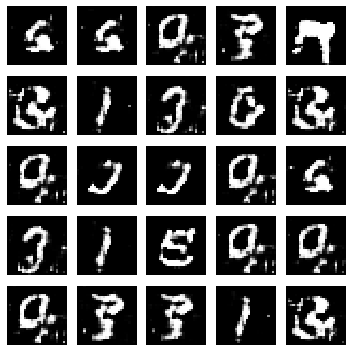

oye hoye
oye hoye
oye hoye
oye hoye
oye hoye
oye hoye
oye hoye
oye hoye
oye hoye
oye hoye


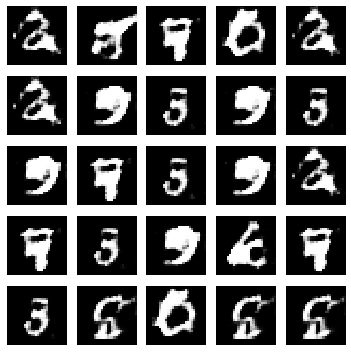

oye hoye


KeyboardInterrupt: ignored

In [27]:
for epoch in range(NUM_EPOCHS):
    epoch_d_loss = 0.
    epoch_g_loss = 0.
    
    for step in range(NO_OF_BATCHES):
        #randomly select 50% real images
        idx = np.random.randint(0,X_Train.shape[0],HALF_BATCH_SIZE)
        real_imgs = X_Train[idx]
        real_classes = Y_Train[idx]
        
        # generate 50% random images
        noise = np.random.normal(0,1,size=(HALF_BATCH_SIZE,NOISE_DIM))
        fake_classes = to_categorical(np.random.randint(0, NUM_CLASSES, HALF_BATCH_SIZE), num_classes=NUM_CLASSES)
        fake_imgs = generator.predict([noise, fake_classes])
        
        
        # one sided label smoothing
        real_y = np.ones((HALF_BATCH_SIZE,1))*0.9 #Label Smoothing, Works well in practice
        fake_y = np.zeros((HALF_BATCH_SIZE,1))
        
        discriminator.trainable = True

        # train on real and fake images
        d_loss_real = discriminator.train_on_batch(real_imgs, [real_y, real_classes]) #updates the weights of discriminator
        d_loss_fake = discriminator.train_on_batch(fake_imgs, [fake_y, fake_classes])

        discriminator.trainable = False 
        
        #Train Generator (Complete Model Generator + Frozen Discriminator)
        
        noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
        real_y = np.ones((BATCH_SIZE,1))
        classes = to_categorical(np.random.randint(0, NUM_CLASSES, BATCH_SIZE), num_classes=NUM_CLASSES)
        g_loss = model.train_on_batch([noise, classes], [real_y, classes])

    print("oye hoye")

    if (epoch+1)%10==0:
        generator.save('models/gan_generator_{0}.h5'.format(epoch+1))
        save_imgs(epoch)
       

    

In [0]:
def gen_imgs(num, samples=25):
    noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
    classes = to_categorical(np.full((samples, 1), num), num_classes=NUM_CLASSES)
    generated_imgs = generator.predict([noise, classes])
    generated_imgs = generated_imgs.reshape(samples,28,28)
    
    plt.figure(figsize=(5,5))
    for i in range(samples):
        plt.subplot(5,5,i+1)
        plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
  

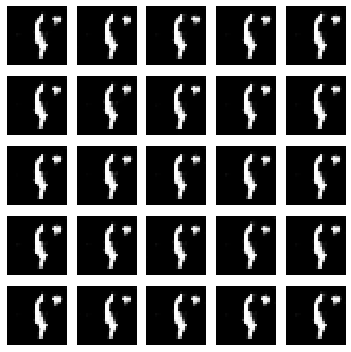

In [38]:
gen_imgs(4, 25)

In [0]:
!zip -r /content/models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/gan_generator_30.h5 (deflated 8%)
  adding: content/models/gan_generator_40.h5 (deflated 8%)
  adding: content/models/gan_generator_10.h5 (deflated 9%)
  adding: content/models/gan_generator_50.h5 (deflated 8%)
  adding: content/models/gan_generator_20.h5 (deflated 8%)


In [0]:
from google.colab import files
files.download("/content/models.zip")

MessageError: ignored

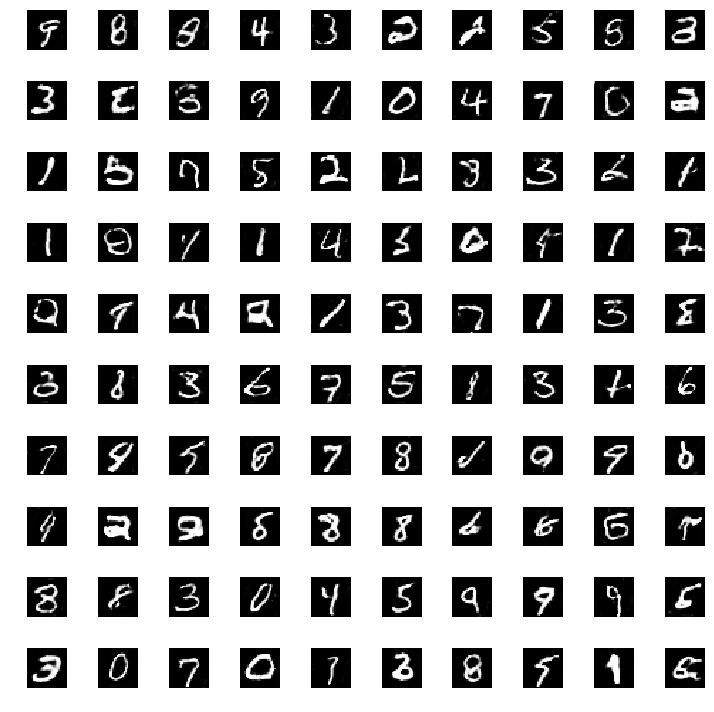

In [0]:
save_imgs(50)